In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def extract_path_from_image(image_path, show=False):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise ValueError("No contour found")
    contour = max(contours, key=lambda c: len(c))
    path = contour[:, 0, :]  # shape (N, 2)
    if show:
        display = img.copy()
        for (x, y) in path:
            cv2.circle(display, (x, y), 1, (0, 0, 255), -1)
        cv2.imshow("Path", display)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return np.array(path)

def generate_motion(path, v0=50, t0=2, dt=0.05):
    # Calculate distances between consecutive points
    distances = np.sqrt(np.sum(np.diff(path, axis=0)**2, axis=1))
    total_length = np.sum(distances)
    accel_distance = 0.5 * v0 * t0
    remaining_distance = total_length - accel_distance
    remaining_time = remaining_distance / v0
    total_time = t0 + remaining_time
    steps = int(total_time / dt)

    # Calculate cumulative distances and time array
    cumulative_dist = np.insert(np.cumsum(distances), 0, 0)
    times = np.linspace(0, total_time, steps)

    # Calculate velocity profile
    velocity_profile = np.piecewise(
        times,
        [times < t0, times >= t0],
        [lambda t: (v0 / t0) * t,
         lambda t: v0]
    )

    # Calculate distance profile
    distance_profile = np.piecewise(
        times,
        [times < t0, times >= t0],
        [lambda t: 0.5 * (v0 / t0) * t**2,
         lambda t: accel_distance + v0 * (t - t0)]
    )

    # Calculate positions
    positions = []
    for d in distance_profile:
        idx = np.searchsorted(cumulative_dist, d)
        if idx >= len(path) - 1:
            idx = len(path) - 2
        ratio = (d - cumulative_dist[idx]) / distances[idx]
        point = (1 - ratio) * path[idx] + ratio * path[idx + 1]
        positions.append(point)
    
    return np.array(positions), velocity_profile

def animate_path(path, vehicle_positions):
    fig, ax = plt.subplots()
    ax.plot(path[:, 0], path[:, 1], 'k-', linewidth=1)
    vehicle_dot, = ax.plot([], [], 'ro', markersize=5)
    ax.set_xlim(path[:, 0].min() - 10, path[:, 0].max() + 10)
    ax.set_ylim(path[:, 1].min() - 10, path[:, 1].max() + 10)
    ax.set_aspect('equal')
    ax.set_title("Vehicle Path Animation")

    def init():
        vehicle_dot.set_data([], [])
        return vehicle_dot,

    def update(frame):
        x = vehicle_positions[frame][0]
        y = vehicle_positions[frame][1]
        vehicle_dot.set_data([x], [y])
        return vehicle_dot,

    ani = FuncAnimation(fig, update, init_func=init, 
                       frames=len(vehicle_positions), 
                       interval=50, blit=True)
    plt.show()

# Main

path = extract_path_from_image("test/test1.png", show=True)
    


Vehicle positions: [[197.         135.        ]
 [197.38284804 136.        ]
 [197.28875146 136.        ]
 ...
 [203.00923344 135.        ]
 [200.50461672 135.        ]
 [198.         135.        ]]


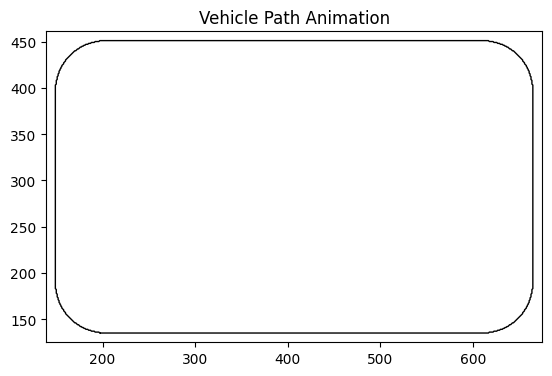

In [13]:
vehicle_positions, velocity_profile = generate_motion(path, v0=50, t0=2, dt=0.05)
print("Vehicle positions:", vehicle_positions)
animate_path(path, vehicle_positions)
